In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# fundamental constants
elec_charge = 1.602e-19
boltzmann = 1.381e-23

# parameters
cap_source = 19.8e-18
cap_drain = 48.0e-18
cap_gate = 5.1e-18

tunnel_source = 1.6e6
tunnel_drain = 1.6e6


# calculated quantities
cap_sum = cap_source + cap_drain + cap_gate
charge_energy = (elec_charge ** 2) / cap_sum


In [3]:
def fermi(pot1, pot2, temp):
    return (
        (temp == 0) * (
            1 * (pot1 < pot2) + 0.5 * (pot1 == pot2)
        ) + 

        (temp != 0) * (
            1 / (1 + np.exp((pot1 - pot2) / (boltzmann * temp)))
        )
    )

In [4]:
def dot_potential(N, vol_source, vol_drain, vol_gate):
    cap_charge = vol_source * cap_source + vol_drain * cap_drain + vol_gate * cap_gate

    return charge_energy * (N - 0.5 - (cap_charge / elec_charge))


def dot_energy(N, vol_source, vol_drain, vol_gate):
    net_charge = -elec_charge * N + vol_source * cap_source + vol_drain * cap_drain + vol_gate * cap_gate

    return (net_charge ** 2) / (2 * cap_sum)


In [5]:
def rate_into_dot(N, vol_source, vol_drain, vol_gate, temp): # represents R_(N, N-1)
    potential_source = -elec_charge * vol_source
    potential_drain = -elec_charge * vol_drain

    potential_dot = dot_potential(N, vol_source, vol_drain, vol_gate)

    rate_drain = tunnel_drain * fermi(potential_dot, potential_drain, temp)
    rate_source = tunnel_source * fermi(potential_dot, potential_source, temp)

    return rate_drain + rate_source

def rate_out_dot(N, vol_source, vol_drain, vol_gate, temp): # represents R_(N, N+1)
    potential_source = -elec_charge * vol_source
    potential_drain = -elec_charge * vol_drain

    potential_dot = dot_potential(N + 1, vol_source, vol_drain, vol_gate)

    rate_drain = tunnel_drain * (1 - fermi(potential_dot, potential_drain, temp))
    rate_source = tunnel_source * (1 - fermi(potential_dot, potential_source, temp))

    return rate_drain + rate_source

In [6]:
# N_max is the upper limit on the number of electrons the simulation considers for the calculation
# Anything above that is considered too improbable to occur
def generate_plot(N_max, vol_source, vol_drain, vol_gate, temp):
    temp = np.array([[[temp]]]).T
    vol_drain = np.array([[vol_drain]]).T
    vol_gate = np.array([vol_gate]).T

    C = np.zeros(N_max + 1)
    C[-1] = 1

    A = np.zeros(shape=(temp.size, vol_drain.size, vol_gate.size, N_max + 1, N_max + 1))

    index = np.arange(N_max)

    # just below main diagonal terms
    # this (in theory) also fills one term in the bottom row
    # that is not correct, but it gets overriden later
    # after it is used for the calculation of the main diagonal terms
    A[:, :, :, index + 1,index] = rate_into_dot(index + 1, vol_source, vol_drain, vol_gate, temp)


    # just above main diagonal terms
    A[:, :, :, index, index + 1] = rate_out_dot(index, vol_source, vol_drain, vol_gate, temp)

    # main diagonal terms
    A[:, :, :, index, index] = - (A[:, :, :, index + 1, index] + A[:, :, :, index - 1, index])

    # bottom row
    A[:, :, :, -1, :] = 1


    P = np.linalg.solve(A, C)

    currentIn = -elec_charge * tunnel_drain * np.sum(
        P[:, :, :, index] * fermi(dot_potential(index + 1, vol_source, vol_drain, vol_gate), -elec_charge * vol_drain, temp)
    ,axis = -1)

    currentOut = -elec_charge * tunnel_drain * np.sum(
        P[:, :, :, index + 1] * (1 - fermi(dot_potential(index + 1, vol_source, vol_drain, vol_gate), -elec_charge * vol_drain, temp))
    ,axis = -1)

    return temp[:, 0, 0, 0], vol_drain[:, 0, 0], vol_gate[:, 0], currentIn - currentOut

In [7]:
temp, vol_drain, vol_gate, current = generate_plot(
    N_max=6,
    vol_source=0,
    vol_drain=np.linspace(-2.5e-3, 2.5e-3, 1001),
    vol_gate=np.linspace(0, 0.13, 1301),
    temp=[0.25]
)

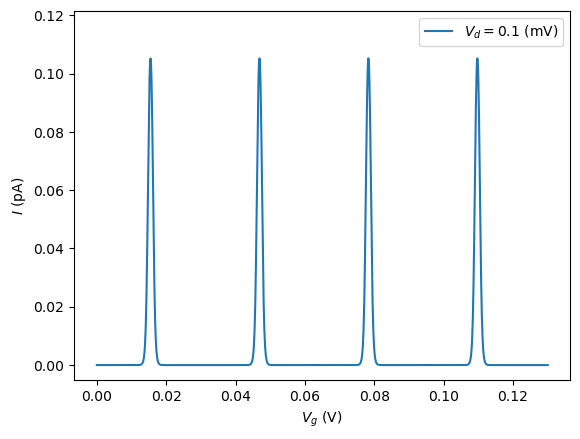

In [8]:
fig, ax = plt.subplots()

ax.plot(vol_gate, current[0, 520] * 1e12, label=f"$V_d = {(vol_drain[520] * 1e3).round(4)}$ (mV)")
ax.legend()

ax.set_xlabel("$V_g$ (V)")
ax.set_ylabel("$I$ (pA)")
ax.set_ybound(upper=ax.get_ybound()[1] * 1.1)

Text(0.5, 1.0, '$I$ (pA)')

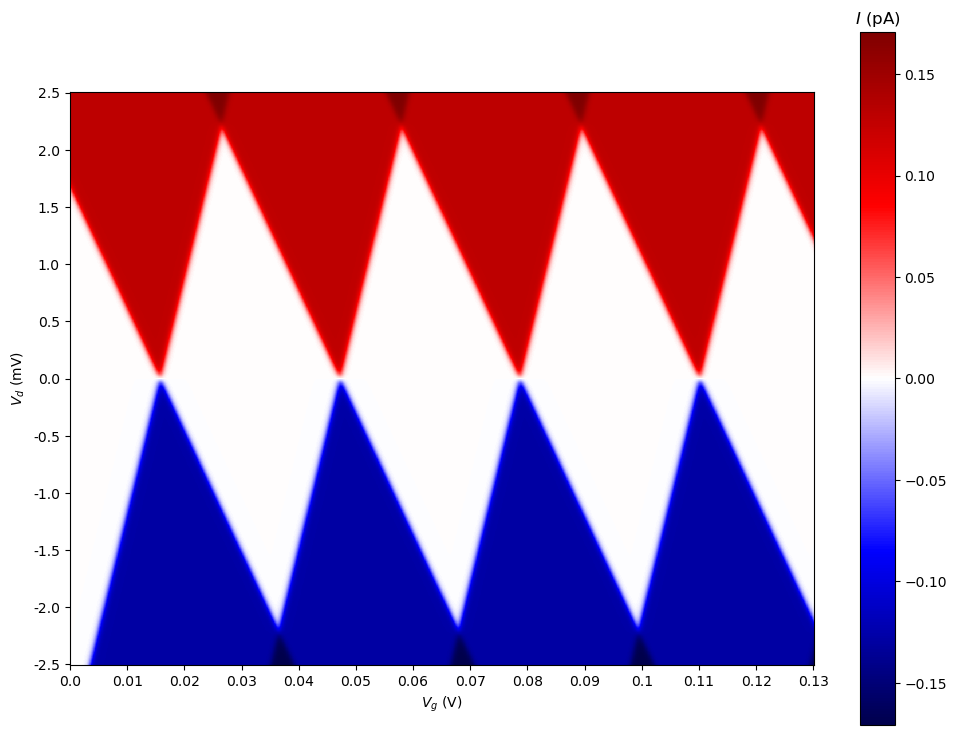

In [9]:
fig, ax = plt.subplots(figsize=(12,9))

pos = ax.imshow(current[0, ::-1] * 1e12, cmap="seismic", interpolation="none")
clb = fig.colorbar(pos, ax=ax)

ax.set_xticks(np.arange(0, 14) * 100, vol_gate[::100].round(2))
ax.set_xlabel("$V_{g}$ (V)")

ax.set_yticks(np.arange(0, 11) * 100, (vol_drain[::-100] * 1e3).round(2))
ax.set_ylabel("$V_{d}$ (mV)")

clb.ax.set_title("$I$ (pA)")

In [10]:
temp, vol_drain, vol_gate, current = generate_plot(
    4,
    0,
    [1e-4],
    np.linspace(0., 0.03, 5001),
    temp=[0.05, 0.5, 2]
)

C:\Users\HP\AppData\Local\Temp\ipykernel_13516\197649000.py:8: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp((pot1 - pot2) / (boltzmann * temp)))


Text(0.5, 0, '$V_g$ (V)')

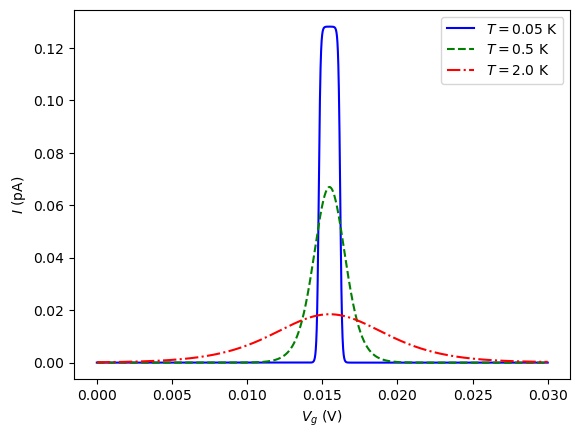

In [11]:
fig, ax = plt.subplots()
ax.plot(vol_gate, current[0, 0] * 1e12, "b", label=f"$T={temp[0]}$ K")
ax.plot(vol_gate, current[1, 0] * 1e12, "g--", label=f"$T={temp[1]}$ K")
ax.plot(vol_gate, current[2, 0] * 1e12, "r-.",label=f"$T={temp[2]}$ K")

ax.legend()
ax.set_ylabel("$I$ (pA)")
ax.set_xlabel("$V_g$ (V)")

In [12]:
def generate_quantum_states_plot(
    vol_source, vol_drain, vol_gate,
    zeeman_energy, excitation_energy,
    temp, deexcitation_rate,
    tunnel_drain, tunnel_source
):
    vol_gate = np.array(vol_gate).T
    vol_drain = np.array([vol_drain]).T
    temp = np.array([[temp]]).T

    energy_0 = dot_energy(0, vol_source, vol_drain, vol_gate)
    energy_1g_down = dot_energy(1, vol_source, vol_drain, vol_gate) - (zeeman_energy / 2)
    energy_1g_up = dot_energy(1, vol_source, vol_drain, vol_gate) + (zeeman_energy / 2)
    energy_1e_down = dot_energy(1, vol_source, vol_drain, vol_gate) + excitation_energy - (zeeman_energy / 2)
    energy_1e_up = dot_energy(1, vol_source, vol_drain, vol_gate) + excitation_energy + (zeeman_energy / 2)
    energy_2 = dot_energy(2, vol_source, vol_drain, vol_gate)

    pot_source = -elec_charge * vol_source
    pot_drain = -elec_charge * vol_drain

    C = np.array([0, 0, 0, 0, 0, 1])

    A = np.zeros(shape=(temp.size, vol_drain.size, vol_gate.size, 6, 6))

    # other state to N=0 state
    A[:, :, :, 0, 1] = tunnel_drain * (1 - fermi(energy_1g_down - energy_0, pot_drain, temp)) + tunnel_source * (1 - fermi(energy_1g_down - energy_0, pot_source, temp))
    A[:, :, :, 0, 2] = tunnel_drain * (1 - fermi(energy_1g_up - energy_0, pot_drain, temp)) + tunnel_source * (1 - fermi(energy_1g_up - energy_0, pot_source, temp))
    A[:, :, :, 0, 3] = tunnel_drain * (1 - fermi(energy_1e_down - energy_0, pot_drain, temp)) + tunnel_source * (1 - fermi(energy_1e_down - energy_0, pot_source, temp))
    A[:, :, :, 0, 4] = tunnel_drain * (1 - fermi(energy_1e_up - energy_0, pot_drain, temp)) + tunnel_source * (1 - fermi(energy_1e_up - energy_0, pot_source, temp))

    # other state to N=1, ground-down state
    A[:, :, :, 1, 0] = tunnel_drain * fermi(energy_1g_down - energy_0, pot_drain, temp) + tunnel_source * fermi(energy_1g_down - energy_0, pot_source, temp)
    A[:, :, :, 1, 3] = deexcitation_rate
    A[:, :, :, 1, 5] = tunnel_drain * (1 - fermi(energy_2 - energy_1g_down, pot_drain, temp)) + tunnel_source * (1 - fermi(energy_2 - energy_1g_down, pot_source, temp))

    # other state to N=1, ground-up state
    A[:, :, :, 2, 0] = tunnel_drain * fermi(energy_1g_up - energy_0, pot_drain, temp) + tunnel_source * fermi(energy_1g_up - energy_0, pot_source, temp)
    A[:, :, :, 2, 4] = deexcitation_rate
    A[:, :, :, 2, 5] = tunnel_drain * (1 - fermi(energy_2 - energy_1g_up, pot_drain, temp)) + tunnel_source * (1 - fermi(energy_2 - energy_1g_up, pot_source, temp))

    # other state to N=1, excited-down state
    A[:, :, :, 3, 0] = tunnel_drain * fermi(energy_1e_down - energy_0, pot_drain, temp) + tunnel_source * fermi(energy_1e_down - energy_0, pot_source, temp)
    A[:, :, :, 3, 5] = tunnel_drain * (1 - fermi(energy_2 - energy_1e_down, pot_drain, temp)) + tunnel_source * (1 - fermi(energy_2 - energy_1e_down, pot_source, temp))

    # other state to N=1, excited-up state
    A[:, :, :, 4, 0] = tunnel_drain * fermi(energy_1e_up - energy_0, pot_drain, temp) + tunnel_source * fermi(energy_1e_up - energy_0, pot_source, temp)
    A[:, :, :, 4, 5] = tunnel_drain * (1 - fermi(energy_2 - energy_1e_up, pot_drain, temp)) + tunnel_source * (1 - fermi(energy_2 - energy_1e_up, pot_source, temp))

    # other state to N=2 state, this will be overridden later
    A[:, :, :, 5, 1] = tunnel_drain * fermi(energy_2 - energy_1g_down, pot_drain, temp) + tunnel_source * fermi(energy_2 - energy_1g_down, pot_source, temp)
    A[:, :, :, 5, 2] = tunnel_drain * fermi(energy_2 - energy_1g_up, pot_drain, temp) + tunnel_source * fermi(energy_2 - energy_1g_up, pot_source, temp)
    A[:, :, :, 5, 3] = tunnel_drain * fermi(energy_2 - energy_1e_down, pot_drain, temp) + tunnel_source * fermi(energy_2 - energy_1e_down, pot_source, temp)
    A[:, :, :, 5, 4] = tunnel_drain * fermi(energy_2 - energy_1e_up, pot_drain, temp) + tunnel_source * fermi(energy_2 - energy_1e_up, pot_source, temp)

    # getting out of a specific state
    index = np.arange(6)
    A[:, :, :, index, index] = - np.sum(A, axis=-2)

    # probability normalization
    A[:, :, :, -1, :] = 1

    # probability calculation
    P = np.linalg.solve(A, C)

    # current calculations
    currentIn_1g_down = P[:, :, :, 0] * fermi(energy_1g_down - energy_0, pot_drain, temp)
    currentIn_1g_up = P[:, :, :, 0] * fermi(energy_1g_up - energy_0, pot_drain, temp)
    currentIn_1e_down = P[:, :, :, 0] * fermi(energy_1e_down - energy_0, pot_drain, temp)
    currentIn_1e_up = P[:, :, :, 0] * fermi(energy_1e_up - energy_0, pot_drain, temp)
    currentIn_1 = currentIn_1g_down + currentIn_1g_up + currentIn_1e_down + currentIn_1e_up

    currentIn_2_from_1g_down = P[:, :, :, 1] * fermi(energy_2 - energy_1g_down, pot_drain, temp)
    currentIn_2_from_1g_up = P[:, :, :, 2] * fermi(energy_2 - energy_1g_up, pot_drain, temp)
    currentIn_2_from_1e_down = P[:, :, :, 3] * fermi(energy_2 - energy_1e_down, pot_drain, temp)
    currentIn_2_from_1e_up = P[:, :, :, 4] * fermi(energy_2 - energy_1e_up, pot_drain, temp)
    currentIn_2 = currentIn_2_from_1g_down + currentIn_2_from_1g_up + currentIn_2_from_1e_down + currentIn_2_from_1e_up

    currentIn = currentIn_1 + currentIn_2


    currentOut_1g_down = P[:, :, :, 1] * (1 - fermi(energy_1g_down - energy_0, pot_drain, temp))
    currentOut_1g_up = P[:, :, :, 2] * (1 - fermi(energy_1g_up - energy_0, pot_drain, temp))
    currentOut_1e_down = P[:, :, :, 3] * (1 - fermi(energy_1e_down - energy_0, pot_drain, temp))
    currentOut_1e_up = P[:, :, :, 4] * (1 - fermi(energy_1e_up - energy_0, pot_drain, temp))
    currentOut_1 = currentOut_1g_down + currentOut_1g_up + currentOut_1e_down + currentOut_1e_up

    currentOut_2_to_1g_down = P[:, :, :, 5] * (1 - fermi(energy_2 - energy_1g_down, pot_drain, temp))
    currentOut_2_to_1g_up = P[:, :, :, 5] * (1 - fermi(energy_2 - energy_1g_up, pot_drain, temp))
    currentOut_2_to_1e_down = P[:, :, :, 5] * (1 - fermi(energy_2 - energy_1e_down, pot_drain, temp))
    currentOut_2_to_1e_up = P[:, :, :, 5] * (1 - fermi(energy_2 - energy_1e_up, pot_drain, temp))
    currentOut_2 = currentOut_2_to_1g_down + currentOut_2_to_1g_up + currentOut_2_to_1e_down + currentOut_2_to_1e_up

    currentOut = currentOut_1 + currentOut_2

    current = -elec_charge * tunnel_drain * (currentIn - currentOut)


    return temp[:, 0, 0], vol_drain[:, 0], vol_gate, current, P

In [13]:
temp, vol_drain, vol_gate, current, P = generate_quantum_states_plot(
    vol_source=0, vol_drain=np.linspace(0, 5e-4, 501), vol_gate=np.linspace(10e-3, 20e-3, 1001),
    zeeman_energy=charge_energy * 1e-2, excitation_energy=charge_energy * 5e-2, 
    temp=[0.04], deexcitation_rate=3e5, tunnel_drain=1.7e6, tunnel_source=1.7e6
)

# ensures that we don't report values beyond the consideration of the algorithm
# i.e. when the N=3 or higher states start becoming prominent
current[P[:,:,:,5] > 0.9] = np.nan

C:\Users\HP\AppData\Local\Temp\ipykernel_13516\197649000.py:8: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp((pot1 - pot2) / (boltzmann * temp)))


Text(0.5, 1.0, '$I$ (pA)')

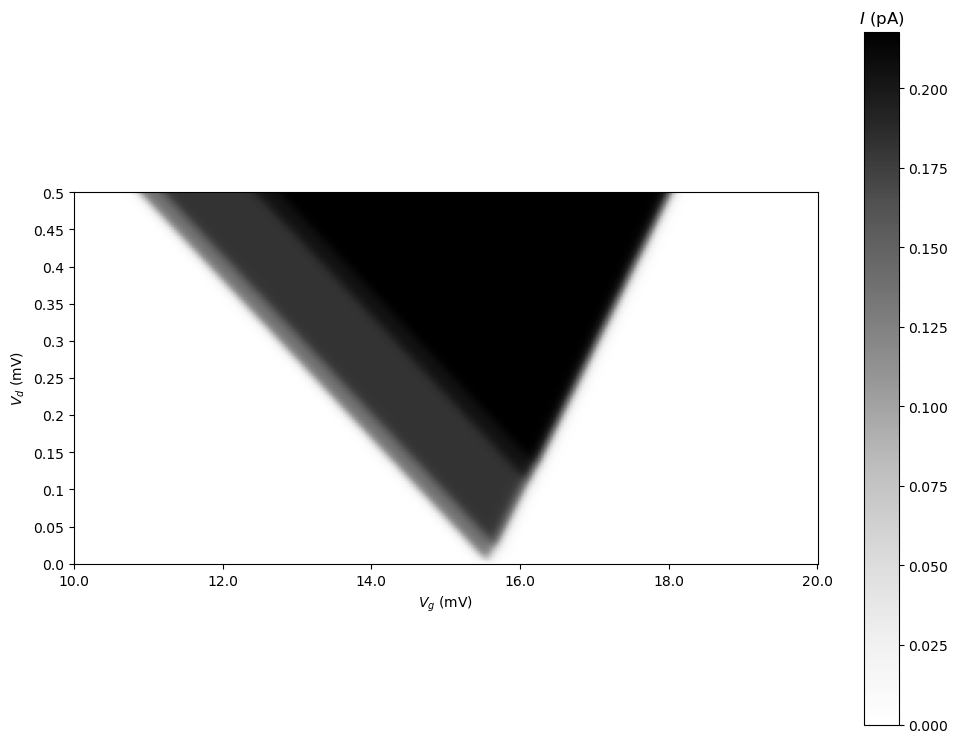

In [21]:
fig, ax = plt.subplots(figsize=(12,9))

pos = ax.imshow(current[0, ::-1] * 1e12, cmap="Grays", interpolation="none")
clb = fig.colorbar(pos, ax=ax)

ax.set_xticks(np.arange(0, 6) * 200, (vol_gate[::200] * 1e3).round(2))
ax.set_xlabel("$V_{g}$ (mV)")

ax.set_yticks(np.arange(0, 11) * 50, (vol_drain[::-50] * 1e3).round(2))
ax.set_ylabel("$V_{d}$ (mV)")

clb.ax.set_title("$I$ (pA)")